- Original Retina Net

In [1]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob

In [2]:
path_root_folder = '/home/sogangori/Downloads/ENA24-detection/'
path_label = path_root_folder + 'ena24.json'
path_image = path_root_folder

os.path.isdir(path_root_folder), os.path.isfile(path_label)

(True, True)

In [3]:
categories= [
    {
      "name": "Bird",
      "id": 0
    },
    {
      "name": "Eastern Gray Squirrel",
      "id": 1
    },
    {
      "name": "Eastern Chipmunk",
      "id": 2
    },
    {
      "name": "Woodchuck",
      "id": 3
    },
    {
      "name": "Wild Turkey",
      "id": 4
    },
    {
      "name": "White_Tailed_Deer",
      "id": 5
    },
    {
      "name": "Virginia Opossum",
      "id": 6
    },
    {
      "name": "Eastern Cottontail",
      "id": 7
    },
    {
      "name": "Human",
      "id": 8
    },
    {
      "name": "Vehicle",
      "id": 9
    },
    {
      "name": "Striped Skunk",
      "id": 10
    },
    {
      "name": "Red Fox",
      "id": 11
    },
    {
      "name": "Eastern Fox Squirrel",
      "id": 12
    },
    {
      "name": "Northern Raccoon",
      "id": 13
    },
    {
      "name": "Grey Fox",
      "id": 14
    },
    {
      "name": "Horse",
      "id": 15
    },
    {
      "name": "Dog",
      "id": 16
    },
    {
      "name": "American Crow",
      "id": 17
    },
    {
      "name": "Chicken",
      "id": 18
    },
    {
      "name": "Domestic Cat",
      "id": 19
    },
    {
      "name": "Coyote",
      "id": 20
    },
    {
      "name": "Bobcat",
      "id": 21
    },
    {
      "name": "American Black Bear",
      "id": 22
    }
  ]

In [4]:
class_names = []
for category in categories:
    d = dict(category)
    #print(d['name'], d['id'])
    class_names.append(d['name'])
    
print(len(class_names), class_names)

23 ['Bird', 'Eastern Gray Squirrel', 'Eastern Chipmunk', 'Woodchuck', 'Wild Turkey', 'White_Tailed_Deer', 'Virginia Opossum', 'Eastern Cottontail', 'Human', 'Vehicle', 'Striped Skunk', 'Red Fox', 'Eastern Fox Squirrel', 'Northern Raccoon', 'Grey Fox', 'Horse', 'Dog', 'American Crow', 'Chicken', 'Domestic Cat', 'Coyote', 'Bobcat', 'American Black Bear']


In [5]:
class_names.insert(0, 'Bg')

In [6]:
anchor_k = 9
head_k=1
num_classes = 80
max_data_m = 100000
level_start = 3
level_end = 8
l1 = 1e-8
activation = 'selu'#'selu'
padded_image_shape = (128*5, 128*8)
kernel_init = tf.initializers.he_normal()
is_pretrain_backbone = False
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)

In [7]:
with open(path_label, 'r') as j:
     contents = json.loads(j.read())

In [8]:
images = contents['images']
annotations = contents['annotations']
print(len(images), images[0])
print(len(annotations), annotations[0])

9676 {'id': '1', 'file_name': '1.jpg', 'width': 1920, 'height': 1080}
11596 {'id': 'd8e94bd2-1df9-11ea-8572-5cf370671a19', 'image_id': '1', 'category_id': 0, 'bbox': [5.47008, 974.4170399999999, 162.279168, 72.97300800000001]}


In [9]:
file_name_id_dict = dict()
for image in images:
    file_name = image['file_name']
    id_num = image['id']    
    file_name_id_dict[file_name] = id_num
len(file_name_id_dict)

9676

In [10]:
id_values = file_name_id_dict.values()
len(id_values), len(set(id_values)), min(id_values), max(id_values)

(9676, 9676, '1', '999')

In [11]:
id_bbox_dict = dict()
multi_object_k = 0
for annotation in annotations:    
    image_id = annotation['image_id']
    bbox = annotation['bbox']
    category_id = annotation['category_id']
    
    image_id = image_id
           
    bbox = np.array(bbox, dtype=np.int)
    x, y, w, h = bbox
    bbox = [int(category_id)+1, y, x, y+h, x+w]
    #print('image_id',image_id, 'category',category_id,'bbox', bbox)
    
    if image_id in id_bbox_dict.keys():
        id_bbox_dict[image_id].extend(bbox)        
        multi_object_k += 1
    else:
        id_bbox_dict[image_id] = bbox
        
len(id_bbox_dict.keys()), multi_object_k

(9676, 1920)

In [12]:
annotation = dict()
for file_name in file_name_id_dict.keys():
    file_full_path = path_image + file_name
        
    file_id = file_name_id_dict[file_name]
    bboxes = id_bbox_dict[file_id]
    bboxes_2d = np.reshape(bboxes, [-1, 5])
    
    if os.path.isfile(file_full_path):        
        annotation[file_full_path] = bboxes_2d
    else:
        continue
len(annotation), type(annotation)

(8789, dict)

In [13]:
input_list = []
bbox_list = []
i = -1
for file_name in file_name_id_dict.keys():
    i += 1
    #if i%10>=2:continue#46.7GB 74%
    if i%6>=2:continue#27.2G > 45G 72%
    file_full_path_train = path_image + file_name
        
    file_id = file_name_id_dict[file_name]
    bboxes = id_bbox_dict[file_id]
    bboxes_2d = np.reshape(bboxes, [-1, 5])
    cls = bboxes_2d[:, :1]
    boxes_2d = bboxes_2d[:, 1:]
        
    if os.path.isfile(file_full_path_train):
        img = Image.open(file_full_path_train)
        img_arr = np.array(img)
                
        h, w, c = img_arr.shape
        scale = np.array((h, w, h, w))
        scale = np.reshape(scale, (1, 4))
        box_norm = boxes_2d.astype(np.float) / scale.astype(np.float)        
        #print(cls, box_norm)
        cls_bbox_norm = np.concatenate((cls, box_norm), axis=1)
        
        input_list.append(img_arr)
        bbox_list.append(cls_bbox_norm)    
        if len(input_list)%100==0:
            print('reading image', len(file_name_id_dict.keys()), i, len(input_list))        
        if len(input_list)>=max_data_m:
            break
print('input_list', len(input_list))

reading image 9676 295 100
reading image 9676 595 200
reading image 9676 895 300
reading image 9676 1195 400
reading image 9676 1495 500
reading image 9676 1795 600
reading image 9676 2257 700
reading image 9676 2557 800
reading image 9676 2857 900
reading image 9676 3157 1000
reading image 9676 3811 1100
reading image 9676 4111 1200
reading image 9676 4698 1300
reading image 9676 5023 1400
reading image 9676 5340 1500
reading image 9676 5641 1600
reading image 9676 5953 1700
reading image 9676 6271 1800
reading image 9676 6571 1900
reading image 9676 6888 2000
reading image 9676 7188 2100
reading image 9676 7488 2200
reading image 9676 7788 2300
reading image 9676 8088 2400
reading image 9676 8388 2500
reading image 9676 8688 2600
reading image 9676 8988 2700
reading image 9676 9288 2800
reading image 9676 9588 2900
input_list 2929


In [14]:
def visualize_detections_gt(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 3] - boxes[:, 1]
    boxes_height = boxes[:, 2] - boxes[:, 0]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        y1, x1, y2, x2 = box        
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        cls = int(cls)
        txt = str(cls)+' '+ class_names[int(cls)]
        ax.text(x1, y1, txt, bbox={"facecolor": (0,0,1), "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
   
    plt.show()
    return ax

In [ ]:
for i in range(len(input_list)):
    if i%5==0:
        img_arr = input_list[i]
        sample_box = bbox_list[i]
        label = sample_box[:, 0]
        bbox = sample_box[:, 1:]

        h, w, c = img_arr.shape
        scale = np.array((h, w, h, w))
        scale = np.reshape(scale, (1, 4))
        bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
        #print('bbox_norm', bbox, bbox_norm)
        ax = visualize_detections_gt(img_arr,bbox_norm,label)

(3238, 5)
cls {1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}


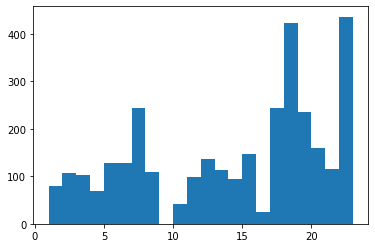

In [15]:
cbbox = np.concatenate(bbox_list, 0)
print(cbbox.shape)
cls = cbbox[:, 0].astype(np.int)
print('cls', set(cls))
h = plt.hist(cls, bins=len(set(cls)))

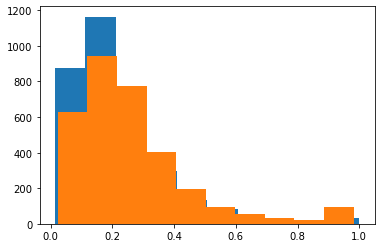

In [16]:
box_w = cbbox[:, -2] - cbbox[:, -4]
box_h = cbbox[:, -1] - cbbox[:, -3]
h = plt.hist(box_h)
h = plt.hist(box_w)

In [17]:
def tile_object(X, BBOX):
    #bbox: cls, y0, x0, y1, x1
    crop_xs = []
    crop_bboxs = []
    dst_img_h, dst_img_w = padded_image_shape
    crop_img_h = dst_img_h//2
    crop_img_w = dst_img_w//2
    for i in range(len(X)):
        x = X[i]
        img_h, img_w, img_c = x.shape
        bbox = BBOX[i]
        #print('len', len(x), len(bbox), x.shape, bbox.shape)
        cls = bbox[:, 0]
        y0 = bbox[:, 1]
        x0 = bbox[:, 2]
        y1 = bbox[:, 3]
        x1 = bbox[:, 4]
        box_h = y1 - y0
        box_w = x1 - x0
        box_y_min = np.min(y0)
        box_x_min = np.min(x0)        
        box_y_max = np.max(y1)
        box_x_max = np.max(x1)        
        if box_y_max - box_y_min < 0.5 and box_x_max - box_x_min < 0.5:
            cy = np.mean((box_y_min + box_y_max)/2)
            cx = np.mean((box_x_min + box_x_max)/2)
            if cy < 0.5:
                ty0 = np.maximum(0, cy - 0.25)
                ty1 = ty0 + 0.5
            else:
                ty1 = np.minimum(1.0, cy + 0.25)
                ty0 = ty1 - 0.5
            if cx < 0.5:
                tx0 = np.maximum(0, cx - 0.25)
                tx1 = tx0 + 0.5
            else:
                tx1 = np.minimum(1.0, cx + 0.25)
                tx0 = tx1 - 0.5
                        
            tbox = np.stack((cls, (y0 - ty0)*2, (x0 - tx0)*2, (y1 - ty0)*2, (x1 - tx0)*2), axis=1)
            img_y0 = int(ty0 * img_h)
            img_y1 = img_y0 + img_h//2
            img_x0 = int(tx0 * img_w)
            img_x1 = img_x0 + img_w//2
            timg = x[img_y0:img_y1, img_x0:img_x1]
            
            img = Image.fromarray(timg)
            img_resized = img.resize((crop_img_w, crop_img_h))
            timg = np.array(img_resized)
            #print(x.shape, 'crop', 'cxy', cy,cx, ty0, tx0, ty1, tx1)
            #print('x_crop', img_y0, img_y1, img_x0,img_x1)
            crop_xs.append(timg)
            crop_bboxs.append(tbox)
    return crop_xs, crop_bboxs


In [18]:
def attach_tiled_data(X, BBOX):
    m = len(X)
    attach_m = int(np.ceil(m/4.0))
    attach_xs = []
    attach_bboxs = []
    #img_h, img_w, img_c = X[0].shape
    dst_img_h, dst_img_w = padded_image_shape
    for i in range(attach_m):
        attach_xs.append(np.zeros((dst_img_h, dst_img_w, 3)))    
        attach_bboxs.append([])
    
    m_rand = np.arange(m)
    np.random.shuffle(m_rand)
    for i in range(len(m_rand)):
        j = m_rand[i]
        x = X[j]
        bbox = BBOX[j]
        if False:
            img = Image.fromarray(x)
            img_resized = img.resize((dst_img_w//2, dst_img_h//2))
            x = np.array(img_resized)
        img_h, img_w, img_c = x.shape
        ti = i//4
        if i%4==0:
            attach_xs[ti][:img_h, :img_w] = x         
            bbox = np.concatenate((bbox[:, 0:1], bbox[:, 1:]*0.5), axis=1)
            attach_bboxs[ti].extend(bbox)
        elif i%4==1:
            attach_xs[ti][:img_h, -img_w:] = x            
            bbox = np.stack((bbox[:, 0], bbox[:, 1]*0.5,bbox[:, 2]*0.5+0.5,bbox[:, 3]*0.5,bbox[:, 4]*0.5+0.5), axis=1)
            attach_bboxs[ti].extend(bbox)
        elif i%4==2:
            attach_xs[ti][-img_h:, :img_w] = x            
            bbox = np.stack((bbox[:, 0], bbox[:, 1]*0.5+0.5,bbox[:, 2]*0.5,bbox[:, 3]*0.5+0.5,bbox[:, 4]*0.5), axis=1)
            attach_bboxs[ti].extend(bbox)
        elif i%4==3:
            attach_xs[ti][-img_h:, -img_w:] = x            
            bbox = np.stack((bbox[:, 0], bbox[:, 1]*0.5+0.5,bbox[:, 2]*0.5+0.5,bbox[:, 3]*0.5+0.5,bbox[:, 4]*0.5+0.5), axis=1)
            attach_bboxs[ti].extend(bbox)
            
    for i in range(len(attach_bboxs)):
        attach_bboxs[i] = np.stack(attach_bboxs[i], 0)
    return attach_xs, attach_bboxs



In [19]:
def box_convert_cxy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate(( (y0+y1)/2, (x0+x1)/2 ), axis=1)

def box_swap_xy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate((x0, y0, x1, y1), axis=1)

def box_convert_to_xywh(boxes):
    return np.concatenate(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,    )

def box_convert_to_corners(boxes):    
    return np.concatenate(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,    )

def angle_to_radian(angle):
    radian = angle * np.pi/180
    return radian
    
def gen_rotate_data(X, BBOX, angle):
    rotate_xs = []
    rotate_bboxs = []
    m = len(X)
    for i in range(m):        
        x = X[i]
        
        bbox = BBOX[i]
        cls = bbox[:, 0]
        y0 = bbox[:, 1]
        x0 = bbox[:, 2]
        y1 = bbox[:, 3]
        x1 = bbox[:, 4]
        
        box = box_swap_xy(bbox[:, 1:])
        box_xywh = box_convert_to_xywh(box)
        box_xy = box_xywh[:, :2] 
        box_wh = box_xywh[:, 2:] 
        box_uv = (np.reshape(box_xy, [-1, 2]) - 0.5) * 2
        
        img_h, img_w, img_c = x.shape
        img = Image.fromarray(x)        
        scale_mat = np.array([1, 0, 0, 1.0*img_h/img_w]).reshape((2,2))
        scale_mat_rev = np.array([1, 0, 0, 1.0*img_w/img_h]).reshape((2,2))
        
        radian = angle_to_radian(angle)        
        rotate_mat = np.array([np.cos(radian), -np.sin(radian), np.sin(radian), np.cos(radian)])        
        rotate_mat = np.reshape(rotate_mat, (2, 2))
        box_uv_trans = np.matmul(box_uv, scale_mat)
        box_uv_trans = np.matmul(box_uv_trans, rotate_mat)
        box_uv_trans = np.matmul(box_uv_trans, scale_mat_rev)
        box_trans = (box_uv_trans + 1)/2
        box_trans_xy = np.reshape(box_trans, [-1, 2])
        box_trans_xywh = np.concatenate((box_trans_xy, box_wh), axis=1)
        box_trans = box_convert_to_corners(box_trans_xywh)
        box_trans = box_swap_xy(box_trans)
        
        if np.min(box_trans)<0 or np.max(box_trans)>1:
            continue
        
        bbox_trans = np.concatenate((np.expand_dims(cls, 1), box_trans), axis=1)
        #print('bbox', bbox[:, 1:])
        #print('box_uv_trans', box_trans)
        img_rotated = img.rotate(angle)
        #plt.imshow(img_rotated)
        rotate_xs.append(np.array(img_rotated))
        rotate_bboxs.append(bbox_trans)
    return rotate_xs, rotate_bboxs        

rotate_xs, rotate_bboxs = gen_rotate_data(crop_xs, crop_bboxs, angle=2)
rotate_xs_, rotate_bboxs_ = gen_rotate_data(crop_xs, crop_bboxs, angle=-2)
print('rotate_xs', len(rotate_xs), len(rotate_bboxs))

In [20]:
def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            scale = np.array((h, w, h, w))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_gt(img_arr,bbox_norm,label)

In [21]:
m = len(input_list)
print('m', m)
m = m - m%2
input_list = input_list[:m]
bbox_list = bbox_list[:m]
input_list_train = input_list[::2]
input_list_test = input_list[1::2]
bbox_list_train = bbox_list[::2]
bbox_list_test = bbox_list[1::2]
print('bbox_list_train', len(bbox_list), len(bbox_list_train), len(bbox_list_test))

m 2929
bbox_list_train 2928 1464 1464


In [22]:
crop_xs, crop_bboxs = tile_object(input_list_train, bbox_list_train)
print('crop_xs', len(crop_xs), len(crop_bboxs))

crop_xs 1251 1251


In [23]:
rotate_xs, rotate_bboxs = gen_rotate_data(crop_xs, crop_bboxs, angle=2)
rotate_xs_, rotate_bboxs_ = gen_rotate_data(crop_xs, crop_bboxs, angle=-2)
print('rotate_xs', len(rotate_xs), len(rotate_bboxs))

rotate_xs 1222 1222


In [24]:
crop_xs.extend(rotate_xs)
crop_bboxs.extend(rotate_bboxs)
crop_xs.extend(rotate_xs_)
crop_bboxs.extend(rotate_bboxs_)
print('crop_xs', len(crop_xs), len(crop_bboxs))

crop_xs 3679 3679


In [25]:
attach_xs, attach_bboxs = attach_tiled_data(crop_xs, crop_bboxs)
print('attach_xs', len(attach_xs), len(attach_bboxs))

attach_xs 920 920


In [26]:
print('len', len(input_list_train), len(crop_xs), len(attach_xs))

len 1464 3679 920


In [209]:
for i in range(len(attach_xs)):
    input_list_train.insert(i*4, attach_xs[i])
    bbox_list_train.insert(i*4, attach_bboxs[i])
if False:
    for i in range(len(crop_xs)):
        input_list_train.insert(1+i*3, crop_xs[i])
        bbox_list_train.insert(1+i*3, crop_bboxs[i])    
print('len', len(input_list_train), len(crop_xs), len(attach_xs))

len 2168 2166 2168


In [27]:
input_list_train = attach_xs
bbox_list_train = attach_bboxs
print('len', len(input_list_train), len(bbox_list_train))

len 920 920


crop_xs.extend(rotate_xs)
crop_bboxs.extend(rotate_bboxs)
crop_xs.extend(rotate_xs_)
crop_bboxs.extend(rotate_bboxs_)
print('crop_xs', len(crop_xs), len(crop_bboxs))

display_data(crop_xs, crop_bboxs, stride=1)

attach_xs, attach_bboxs = attach_tiled_data(crop_xs, crop_bboxs)
print('attach_xs', len(attach_xs), len(attach_bboxs))

display_data(rotate_xs_, rotate_bboxs_, stride=20)

display_data(attach_xs, attach_bboxs)

display_data(crop_xs, crop_bboxs, stride=10)

for i in range(len(attach_xs)):
    input_list_train.insert(i*4, attach_xs[i])
    bbox_list_train.insert(i*4, attach_bboxs[i])
if False:
    for i in range(len(crop_xs)):
        input_list_train.insert(1+i*3, crop_xs[i])
        bbox_list_train.insert(1+i*3, crop_bboxs[i])    
print('len', len(input_list_train), len(crop_xs), len(attach_xs))

input_list_train = attach_xs
bbox_list_train = attach_bboxs
print('len', len(input_list_train), len(crop_xs), len(attach_xs))

0 [ 5. 16. 18. 23.]


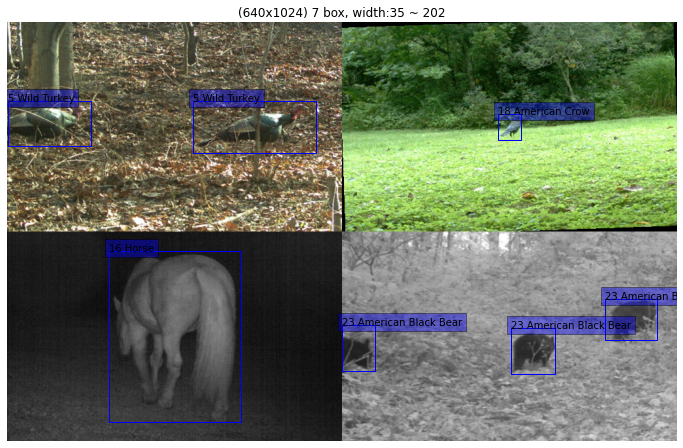

100 [ 7. 17. 19. 23.]


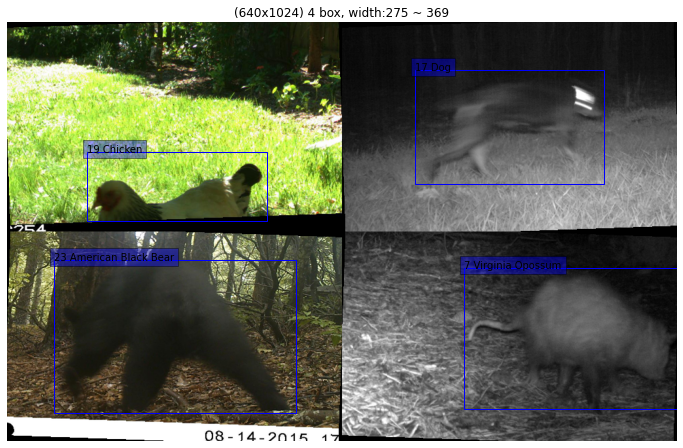

200 [ 7. 17. 18. 20.]


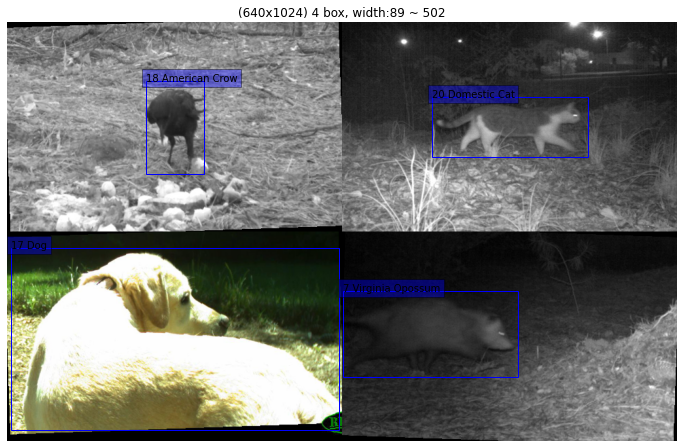

300 [12. 13. 15.]


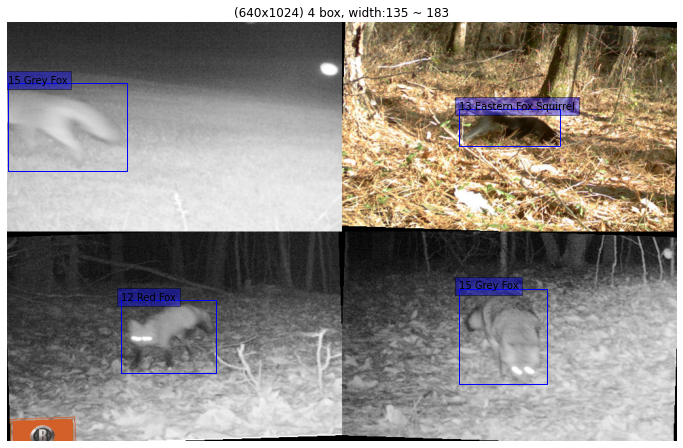

400 [13. 15. 18. 23.]


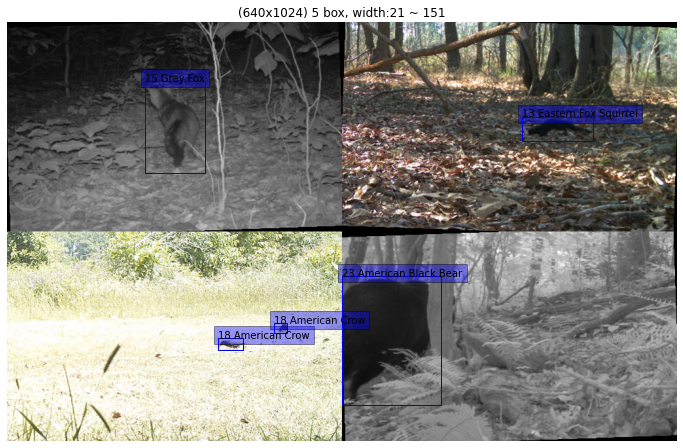

500 [ 7. 12. 13. 21.]


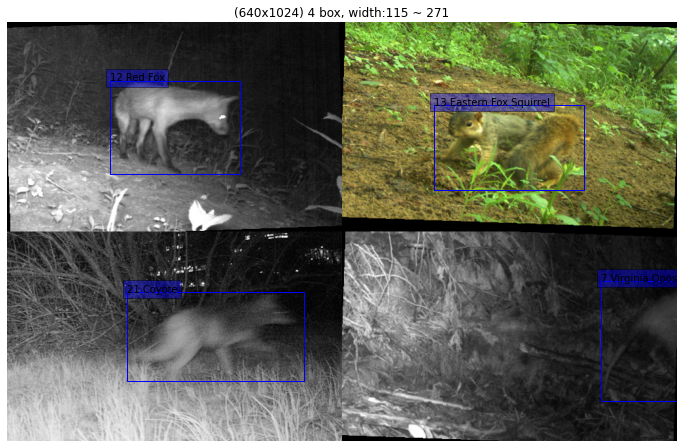

600 [17. 19. 21. 22.]


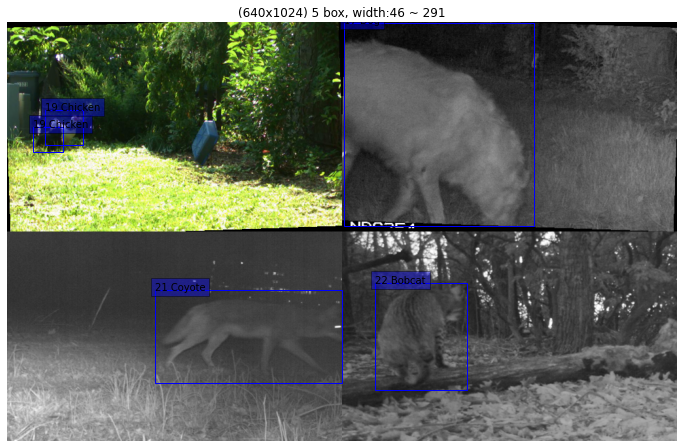

700 [ 2.  3. 18. 23.]


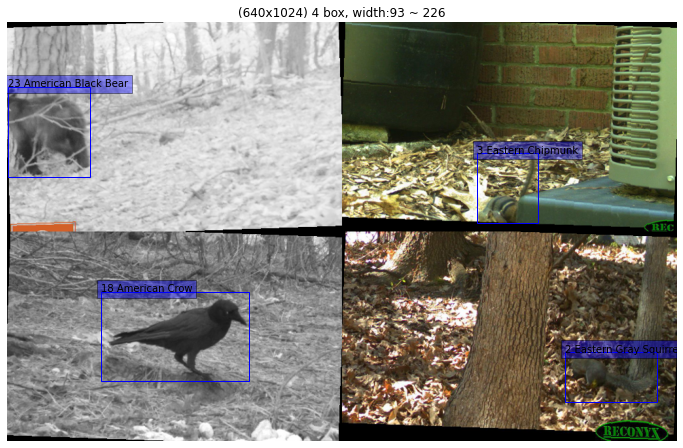

800 [15. 19. 21. 22.]


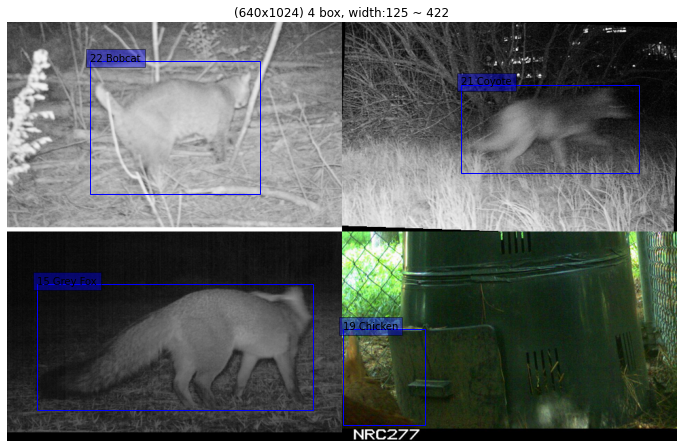

900 [19. 20. 23.]


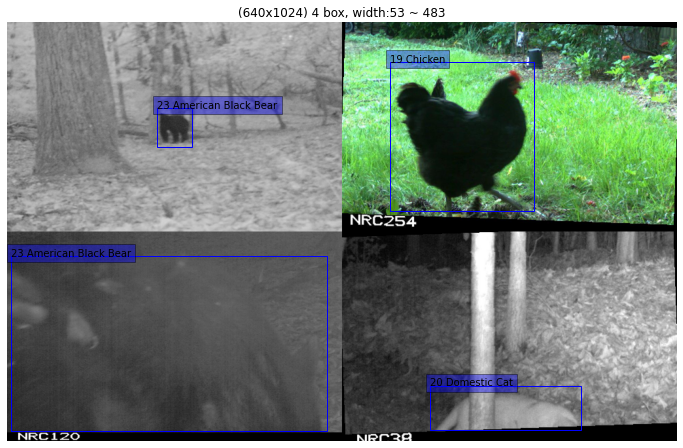

In [28]:
display_data(input_list_train, bbox_list_train, stride=100)

In [29]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""

def compute_iou(boxes1, boxes2):#compute_iou(anchor_boxes, gt_boxes)
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(10, 10), linewidth=1, color=[0, 0, 1], 
    boxes_gt=None):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()        
   
    #class_names = [visdrone_categories[(int(x))] for x in classes]
    if boxes_gt is not None:
        for box in boxes_gt:        
            y1, x1, y2, x2 = box
            w, h = x2 - x1, y2 - y1
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=[0,1,0], linewidth=2
            )
            ax.add_patch(patch)
            
    for box, _cls, score in zip(boxes, classes, scores):
        #text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        color_text = edgecolors[_cls]
        color = [0, 0, 1]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        cls_name = class_names[max(0,_cls)]
        score_txt = str.format('%s %.2f' %(cls_name, score))
        ax.text(x1, y1, score_txt, bbox={"facecolor": color_text, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
   
        
    plt.show()
    return ax


In [30]:

"""
## Implementing Anchor generator
Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).
"""
class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.level_start = level_start
        self.level_end = level_end
        
        if anchor_k==9:
            self.aspect_ratios = [0.5, 1.0, 2.0]        
            self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        else:
            self.aspect_ratios = [1.0]        
            self.scales = [2 ** x for x in [0]]
                
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        #self._strides = [2 ** i for i in range(3, 8)]
        #self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._strides = [2 ** i for i in range(self.level_start, self.level_end)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 196.0, 256.0]]
        #self._areas = [x ** 2 for x in [64.0, 128.0, 196.0, 256.0]]
        
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - self.level_start]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - self.level_start], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return tf.concat(anchors, axis=0)
    
    def get_anchors_check(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return anchors

In [31]:
level_start, level_end

(3, 8)

In [32]:
anchor_check = AnchorBox()

In [33]:
anchors = anchor_check.get_anchors_check(128,128)
for anchor in anchors:
    print(anchor.shape, anchor[-1])

(2304, 4) tf.Tensor([124.       124.        71.83757   35.918785], shape=(4,), dtype=float32)
(576, 4) tf.Tensor([120.      120.      143.67514  71.83757], shape=(4,), dtype=float32)
(144, 4) tf.Tensor([112.      112.      287.35028 143.67514], shape=(4,), dtype=float32)
(36, 4) tf.Tensor([ 96.       96.      440.0051  220.00255], shape=(4,), dtype=float32)
(9, 4) tf.Tensor([ 64.       64.      574.70056 287.35028], shape=(4,), dtype=float32)


In [79]:
"""
## Preprocessing data
Preprocessing the images involves two steps:
- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.
Along with the images, bounding boxes are rescaled and flipped if required.
"""

def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
        
    return image, boxes

def resize_and_pad_image_bbox(
    image, bbox, min_side=1024.0, max_side=11333.0, jitter=[128*8-16, 128*8+1], stride=128.0
):
    #bbox (x, y, x, y)
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    image_h = image_shape[0]
    image_w = image_shape[1]    
    #padded_image_shape = (1024, 1920)
    #padded_image_shape = (128*8, 128*15)    
    ratio = (1, 1)    
    image = tf.image.resize(image, padded_image_shape)
    return image, padded_image_shape, ratio, bbox


def resize_and_pad_image_bbox_original(
    image, bbox, min_side=128.0*5, max_side=1024.0*4, jitter=[128*4-32, 128*5-64], stride=128.0
):    
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    ratio_jitter = tf.random.uniform(tf.shape(image_shape), -32, 32, dtype=tf.float32)
    image_shape += ratio_jitter #new        
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    padded_image_shape = tf.cast(padded_image_shape, tf.float32)              
    pad_ratio = tf.cast(image_shape, tf.float32) / padded_image_shape
    bbox_padded = tf.stack(
        [
            bbox[:, 0] * pad_ratio[1],
            bbox[:, 1] * pad_ratio[0],
            bbox[:, 2] * pad_ratio[1],
            bbox[:, 3] * pad_ratio[0],
        ],
        axis=-1,
    )
    return image, padded_image_shape, ratio, bbox_padded

def resize_and_pad_image(
    image, min_side=1024.0, max_side=11333.0, jitter=[128*8-3, 128*8], stride=128.0
):
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    image = tf.image.resize(image, tf.cast(padded_image_shape, dtype=tf.int32))   
    ratio = tf.cast(padded_image_shape, dtype=tf.float32)/image_shape
    ratio = tf.concat((ratio, ratio), 0)[::-1]
    return image, padded_image_shape, ratio


def preprocess_data(image, cls_bbox):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
     
    bbox = swap_xy(cls_bbox[:, 1:])
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)    

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _, bbox = resize_and_pad_image_bbox_original(image, bbox)    
    #image, image_shape, _, bbox = resize_and_pad_image_bbox(image, bbox)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id


def preprocess_test_data(image, cls_bbox):         
    bbox = swap_xy(cls_bbox[:, 1:])
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)    
    image, image_shape, _, bbox = resize_and_pad_image_bbox(image, bbox)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id


In [80]:
"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""

class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.3
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)#from anchor to object-box        
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)    
        positive_mask = tf.greater_equal(max_iou, match_iou)# not only this, but also need max iou cell
        
        positive_proposal_mask = tf.greater_equal(iou_matrix, match_iou)
        positive_mask = tf.reduce_any(positive_proposal_mask, axis=1)
        
        negative_mask = tf.less(max_iou, ignore_iou)
        
        max_iou_anchor = tf.reduce_max(iou_matrix, axis=0, keepdims=True) 
        max_iou_anchor_mask = tf.greater_equal(iou_matrix, max_iou_anchor)
        positive_max_mask = tf.reduce_any(max_iou_anchor_mask, axis=1)
        positive_mask = tf.logical_or(positive_mask, positive_max_mask)#new        
        
        negative_mask = tf.logical_and(negative_mask, tf.logical_not(positive_mask))
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))        
        
        return (
            matched_gt_idx,
            tf.cast(positive_max_mask, dtype=tf.float32),
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        #gt_boxes : bbox = convert_to_xywh(bbox)#original pixel size
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_max_mask, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        matched_gt_boxes_size = tf.reduce_prod(matched_gt_boxes[:, 2:], 1)
        matched_gt_boxes_size = tf.sqrt(matched_gt_boxes_size)        
        
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)    
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), 0.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -1.0, cls_target)       
        cls_target = tf.expand_dims(cls_target, axis=-1)
        positive_max_mask_exp = tf.expand_dims(positive_max_mask, -1)
        label = tf.concat([box_target, cls_target, positive_max_mask_exp, 
                           tf.expand_dims(matched_gt_boxes_size, -1)], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """Creates box and classification targets for a batch"""
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        #batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        batch_images = tf.cast(batch_images, tf.float32)
        return batch_images, labels.stack()

In [81]:
#https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

regulizer = tf.keras.regularizers.L2(l1)
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def relu(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)    
    return relu

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters, 
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(x)    
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(y)   
    
    if downsample:
        x = Conv2D(kernel_size=3,
                   strides=2,
                   filters=filters,
                   activation=activation,
                   padding="same",
                   kernel_regularizer=regulizer)(x)
    out = Add()([x, y])
    out = relu(out)
    return out

def create_resnet_backbone():
    
    inputs = Input(shape=(None, None, 3))    
    num_filters = 64
    
    #t = BatchNormalization()(inputs)    
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(inputs)
    t = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(t)
    
    num_blocks_list = [2, 2, 2, 2]#resnet-18
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):            
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)            
        if i>=1 and len(t_list)<5:
            t_list.append(t)
        num_filters *= 2
    
    #t = AveragePooling2D(4)(t)
    #t = Flatten()(t)
    #outputs = Dense(10, activation='softmax')(t)
    model = Model(inputs, t_list)
    
    return model

In [82]:
"""
## Building the ResNet50 backbone
RetinaNet uses a ResNet based backbone, using which a feature pyramid network
is constructed. In the example we use ResNet50 as the backbone, and return the
feature maps at strides 8, 16 and 32.
"""

"""
## Building Feature Pyramid Network as a custom layer
"""

class FeaturePyramid(keras.layers.Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.
    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """
    #https://github.com/yhenon/pytorch-retinanet/blob/master/retinanet/model.py
    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone# if backbone else create_resnet_backbone()
        regulizer  = tf.keras.regularizers.L2(l1)
        
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
        self.upsample_2x = keras.layers.UpSampling2D(2)
        #self.dropout = keras.layers.Dropout(.1)#20.8.8

    def call(self, images, training=False):                
        c3_output, c4_output, c5_output = self.backbone(images, training=training)    
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(p6_output)
        #8, 16, 32, 64, 128
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [83]:

"""
## Building the classification and box regression heads.
The RetinaNet model has separate heads for bounding box regression and
for predicting class probabilities for the objects. These heads are shared
between all the feature maps of the feature pyramid.
"""

def build_head(output_filters, bias_init):
    """Builds the class/box predictions head.
    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_init: Bias Initializer for the final convolution layer.
    Returns:
      A keras sequential model representing either the classification
        or the box regression head depending on `output_filters`.
    """
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])    
    #kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    kernel_init = tf.initializers.he_normal()
    regulizer = tf.keras.regularizers.L2(l1)
    for _ in range(4):#4
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
        )        
    head.add(keras.layers.Dropout(0.1))
    head.add(
        keras.layers.Conv2D(output_filters, 3, 1, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init)
    )
    return head


"""
## Building RetinaNet using a subclassed model
"""

def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

def image_color_augment(x):
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    if tf.random.uniform(()) > 0.5:
        gray = tf.image.rgb_to_grayscale(x)
        x = tf.concat((gray, gray, gray), -1)
    #x = tf.image.random_jpeg_quality(x, 0, 1.0)
    x = tf.clip_by_value(x, 0, 1)
    #image = tf.image.adjust_saturation(image, tf.random.uniform((), minval=-0.5, maxval=0.5))
    #image = tf.image.adjust_brightness(image, tf.random.uniform((), minval=0.0, maxval=0.5))#[0,1)
    #image = tf.image.adjust_hue(image, tf.random.uniform((), minval=-0.5, maxval=0.5))#[-1, 1]    
    return x

class RetinaNet(keras.Model):
    """A subclassed Keras model implementing the RetinaNet architecture.
    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, num_classes, anchor_k, backbone=None, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        if is_pretrain_backbone:
            backbone = get_backbone()                    
        else:
            backbone = create_resnet_backbone()
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes                
        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        
        self.head_k = head_k
        self.cls_heads = []
        self.box_heads = []
        for i in range(self.head_k):
            self.cls_heads.append(build_head(anchor_k * num_classes, prior_probability))
            self.box_heads.append(build_head(anchor_k * 4, "zeros"))
       

    def call(self, image, training=False):
        
        image = tf.cond(tf.reduce_max(image)>10, lambda:image / 255.0, lambda:image)     
        if training: image = image_color_augment(image) #new
        features = self.fpn(image, training=training)        
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        if self.head_k==1:
            cls_head = self.cls_heads[0]
            box_head = self.box_heads[0]
            for feature in features:            
                box_outputs.append(tf.reshape(box_head(feature), [N, -1, 4]))
                cls_outputs.append(
                    tf.reshape(cls_head(feature), [N, -1, self.num_classes])
                )
        else:
            for i in range(len(features)):
                cls_head = self.cls_heads[i]
                box_head = self.box_heads[i]
                box_outputs.append(tf.reshape(box_head(features[i]), [N, -1, 4]))
                cls_outputs.append(tf.reshape(cls_head(features[i]), [N, -1, self.num_classes]))
            
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)


"""
## Implementing a custom layer to decode predictions
"""


class DecodePredictions(tf.keras.layers.Layer):
    """A Keras layer that decodes predictions of the RetinaNet model.
    Attributes:
      num_classes: Number of classes in the dataset
      confidence_threshold: Minimum class probability, below which detections
        are pruned.
      nms_iou_threshold: IOU threshold for the NMS operation
      max_detections_per_class: Maximum number of detections to retain per
       class.
      max_detections: Maximum number of detections to retain across all
        classes.
      box_variance: The scaling factors used to scale the bounding box
        predictions.
    """

    def __init__(
        self,
        num_classes=num_classes,
        confidence_threshold=0.5,
        nms_iou_threshold=0.2,
        max_detections_per_class=200,
        max_detections=200,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        objectness = tf.nn.sigmoid(predictions[:, :, 4:5])
        cls_predictions = objectness
        cls_predictions = tf.nn.softmax(predictions[:, :, 5:])
        cls_predictions = tf.round(objectness) * cls_predictions                 
        
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )


"""
## Implementing Smooth L1 loss and Focal Loss as keras custom losses
"""


class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):    
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        loss = tf.where(loss < 0.01, 0.0, loss)#new marginal loss        
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

        
    def call(self, y_cls, y_pred):
        #shape=(None, None),  shape=(None, None, num_class), dtype=float32)
        #alpha:0.25
        y_hot = tf.one_hot(tf.cast(y_cls, dtype=tf.int32),depth=num_classes, dtype=tf.float32,)
        is_exist_non_human_class = tf.reduce_any(y_cls > 1)
        y_positive = tf.cast(y_cls > 0, tf.float32)
        y_bg = tf.cast(y_cls == 0, tf.float32)        
        objectness = y_pred[:, :, 0] + tf.reduce_mean(y_pred[:, :, 1:]*0, axis=-1)
        pt = tf.nn.sigmoid(objectness)        
                
        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_positive * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (y_bg) * tf.math.log(1 - pt)        
        
        loss_objectness = loss_p + loss_f
        pred_positive_class_prob = tf.nn.softmax(y_pred[:, :, 1:])
        y_hot_positive = y_hot[:, :, 1:]
        pt = tf.clip_by_value(pred_positive_class_prob, 1e-7, 1.0 - 1e-7)
        loss_class = - tf.pow(1.0 - pt, self._gamma) * y_hot_positive * tf.math.log(pt)        
        loss_class = tf.reduce_sum(loss_class, axis=-1)
        loss_class = tf.cast(is_exist_non_human_class, tf.float32) * y_positive * loss_class
        loss = loss_objectness + loss_class
        return loss
    
    def call_original(self, y_cls, y_pred):
        y_true = tf.one_hot(
            tf.cast(y_cls, dtype=tf.int32),
            depth=num_classes,
            dtype=tf.float32,
        )
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        loss = tf.reduce_sum(loss, axis=-1)
        return loss
    

class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # y_pred : tf.concat([box_outputs, cls_outputs], axis=-1)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        y_cls = y_true[:, :, 4]
        positive_max_mask = y_true[:, :, 5] > 0        
        
        cls_predictions = y_pred[:, :, 4:]        
        
        positive_mask = tf.greater(y_cls, 0.0)
        ignore_mask = tf.less(y_cls, 0.0)
        
        clf_loss = self._clf_loss(y_cls, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)               
        
        clf_loss = tf.where(positive_max_mask, 2 * clf_loss, clf_loss)#new for Recall Boost
        clf_loss = tf.where(ignore_mask, 0.0, clf_loss)        
        box_loss = tf.where(positive_mask, box_loss, 0.0)
        
        positive_mask = tf.cast(positive_mask, tf.float32)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)        
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss#new
        return loss
 

In [84]:
num_classes

80

In [85]:
#Metric
def recall(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]        
    h_prob = tf.nn.sigmoid(h_score)
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    
    true_positives = tf.cast(tf.logical_and(y_cls > 0, h_postive>0), tf.float32)
    false_negative = y_positive * (1 - h_postive)
                
    tp = tf.reduce_sum(true_positives, axis=1)
    fn = tf.reduce_sum(false_negative, axis=1)
    tp = tf.cast(tp, tf.float32)
    fn = tf.cast(fn, tf.float32)
    
    rec = tp / (tp + fn + 1e-8)
    return rec

def precision(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)    
    y_cls_symbol = tf.cast(y_cls_symbol != 0, tf.int32)
    h_cls_symbol = tf.round(tf.nn.sigmoid(y_pred[:, :, 4]) )    
    h_cls_symbol = tf.cast(h_cls_symbol, tf.int32)
    
    true_positives = y_cls_symbol * h_cls_symbol
    false_positive = (1 - y_cls_symbol) * h_cls_symbol
    
    ones = tf.ones_like(true_positives)
    zeeros = tf.zeros_like(true_positives)
    true_positives = tf.cast(tf.equal(true_positives, ones), tf.float32)
    false_positive = tf.cast(tf.equal(false_positive, ones), tf.float32)
    
    tp = tf.reduce_sum(true_positives, axis=1)
    fp = tf.reduce_sum(false_positive, axis=1)
    tp = tf.cast(tp, tf.float32)
    fp = tf.cast(fp, tf.float32)
    prec = tp / (tp + fp + 1e-8)
    return prec

def accuracy(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]        
    h_prob = tf.nn.sigmoid(h_score)
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    h_cls = tf.math.argmax(y_pred[:, :, 5:], -1, output_type=tf.int32)        
    acc = tf.boolean_mask(tf.equal(y_cls-1, h_cls), y_positive)    
    return acc

In [87]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
model_dir = "retinanet/animal"
label_encoder = LabelEncoder()

loss_fn = RetinaNetLoss(num_classes)
anchor_k = len(label_encoder._anchor_box.aspect_ratios)*len(label_encoder._anchor_box.scales)
model = RetinaNet(num_classes, anchor_k)


In [88]:
def load_weight():   
    weights_dir = model_dir#"data"
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir)

In [89]:
def generator():
    for i in range(len(input_list_train)):
        x = input_list_train[i]
        y_box = bbox_list_train[i]
        yield (x, y_box)

def generator_test():
    for i in range(len(input_list_test)):
        x = input_list_test[i]
        y_box = bbox_list_test[i]
        yield (x, y_box)
        
dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))
dataset_test = tf.data.Dataset.from_generator(
    generator_test, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))
dataset
np.set_printoptions(precision=2)
for example in tfds.as_numpy(dataset):
    image = example[0]
    bbox = example[1]    
    print(image.dtype, image.shape, bbox.shape, bbox[0])
    break

uint8 (640, 1024, 3) (7, 5) [5.   0.19 0.   0.29 0.12]


In [90]:
batch_size = 7 #8 OOM
autotune = tf.data.experimental.AUTOTUNE
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
#train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = dataset_test.map(preprocess_test_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

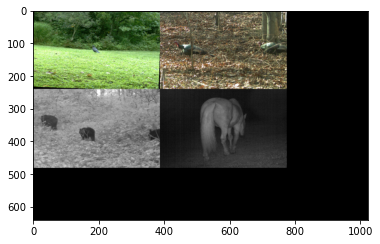

In [91]:
for image, cbbox in train_dataset: 
    img = image[0].numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()
    break
    

In [92]:
np.set_printoptions(linewidth=200)

image_height, image_width = padded_image_shape

anchor_feature_size = [(np.ceil(image_height / 2 ** i), np.ceil(image_width / 2 ** i)) 
                       for i in range(level_start, level_end)]
print('anchor_feature_size', anchor_feature_size)
img_check = 0
i = 0
for image, cbbox in train_dataset:         
    bbox = cbbox[:, :, :4]
    cls_gt = cbbox[:,:,4]
    size_gt = cbbox[:,:,-1]
    m = len(cbbox)
    small_count = np.sum(np.logical_and(cls_gt>0, np.logical_and(size_gt< 6*6, size_gt>=0.5)))
    positive_count = np.sum(cls_gt>0)

    print('cbbox', cbbox.shape)
    print('cls_sum',np.sum(cls_gt < 0.0), np.sum(cls_gt == 0.0), 
          np.sum(cls_gt == 1.0), np.sum(cls_gt > 1.0))
    print('cls_mean',np.mean(cls_gt < 0.0), np.mean(cls_gt == 0.0), 
          np.mean(cls_gt == 1.0), np.mean(cls_gt > 0.0))
    print('shape',image.shape, cbbox.shape, np.unique(cls_gt))
    print('anchor_feature_size', anchor_feature_size)
    offset = 0
    positive_maps = []
    for anchor_feature_size_1 in anchor_feature_size:        
        fm_h, fm_w = anchor_feature_size_1
        fm_h = int(fm_h)
        fm_w = int(fm_w)        
        fm_wh = int(fm_h * fm_w * anchor_k)
        cbbox_anchor = cbbox[:, offset:offset+fm_wh, 4]
        cbbox_anchor = np.reshape(cbbox_anchor, [m, fm_h, fm_w, anchor_k])
        coount_m1 = np.count_nonzero(cbbox_anchor==-1)
        coount_0 = np.count_nonzero(cbbox_anchor==0)
        coount_1 = np.count_nonzero(cbbox_anchor==1)
        coount_1_over = np.count_nonzero(cbbox_anchor>1)
        positive_ratio = np.mean(cbbox_anchor>0)
        positive_maps.append(cbbox_anchor>0)
        print('cbbox_anchor', cbbox_anchor.shape, coount_m1, coount_0, coount_1, coount_1_over, 'ratio', positive_ratio)
        sample_0_cbbox = cbbox_anchor[0]
        sample_0_cbbox_sum = np.max(sample_0_cbbox, -1).astype(np.int)
        
        #sample_img = ((1+sample_0_cbbox_sum)*80).astype(np.uint8)
        #plt.imshow(sample_img)
        offset += fm_wh
        if False:            
            file_name = str(fm_h)+ '_' + str(fm_w)+ '.txt'
            np.savetxt(file_name,sample_0_cbbox_sum, fmt='%d',delimiter='')
    img_check = image
    i +=2
    if i>2:break

anchor_feature_size [(80.0, 128.0), (40.0, 64.0), (20.0, 32.0), (10.0, 16.0), (5.0, 8.0)]
cbbox (7, 122760, 7)
cls_sum 7324 850902 61 1033
cls_mean 0.008523018200437556 0.990203882139366 7.098636130894195e-05 0.0012730996601964344
shape (7, 640, 1024, 3) (7, 122760, 7) [-1.  0.  1.  2.  3.  5.  6.  7.  8. 11. 12. 13. 14. 16. 17. 18. 19. 22. 23.]
anchor_feature_size [(80.0, 128.0), (40.0, 64.0), (20.0, 32.0), (10.0, 16.0), (5.0, 8.0)]
cbbox_anchor (7, 80, 128, 9) 2351 642446 17 306 ratio 0.0005006820436507936
cbbox_anchor (7, 40, 64, 9) 2567 158362 42 309 ratio 0.002176339285714286
cbbox_anchor (7, 20, 32, 9) 1733 38254 2 331 ratio 0.008258928571428572
cbbox_anchor (7, 10, 16, 9) 562 9434 0 84 ratio 0.008333333333333333
cbbox_anchor (7, 5, 8, 9) 111 2406 0 3 ratio 0.0011904761904761906
cbbox (7, 122760, 7)
cls_sum 6391 851971 0 958
cls_mean 0.0074372759856630825 0.9914478890285342 0.0 0.0011148349858027277
shape (7, 640, 1024, 3) (7, 122760, 7) [-1.  0.  2.  3.  4.  5.  6.  7.  8. 12. 1

Text(0.5, 1.0, '(6, 80, 128, 9)0.00021701388888888888 20')

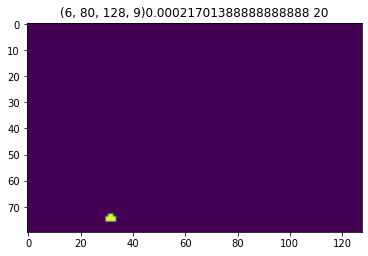

In [48]:
plt.imshow(np.max(positive_maps[0][0], -1))
plt.title(str(positive_maps[0].shape)+ str(np.mean(positive_maps[0][0]))+ ' ' + str(np.sum(positive_maps[0][0])))

Text(0.5, 1.0, '(6, 40, 64, 9)0.0019097222222222222')

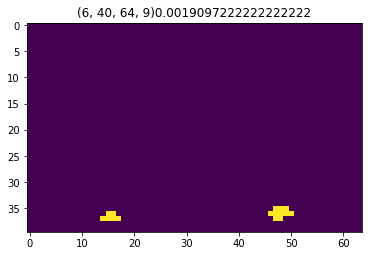

In [49]:
plt.imshow(np.max(positive_maps[1][0], -1))
plt.title(str(positive_maps[1].shape) + str(np.mean(positive_maps[1][0]) ))

Text(0.5, 1.0, '(6, 20, 32, 9)0.009375')

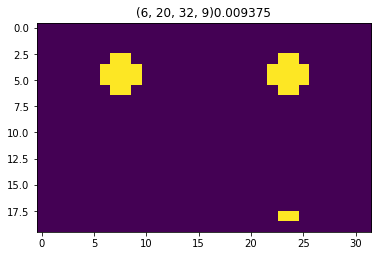

In [50]:
plt.imshow(np.max(positive_maps[2][0], -1))
plt.title(str(positive_maps[2].shape) + str(np.mean(positive_maps[2][0]) ))

In [51]:
pmap0 = np.array(Image.fromarray(np.max(positive_maps[0][0],-1)).resize(padded_image_shape[::-1]))
pmap1 = np.array(Image.fromarray(np.max(positive_maps[1][0],-1)).resize(padded_image_shape[::-1]))
pmap2 = np.array(Image.fromarray(np.max(positive_maps[2][0],-1)).resize(padded_image_shape[::-1]))
pmap3 = np.array(Image.fromarray(np.max(positive_maps[3][0],-1)).resize(padded_image_shape[::-1]))
pmap4 = np.array(Image.fromarray(np.max(positive_maps[3][0],-1)).resize(padded_image_shape[::-1]))
pmap0 = pmap0.astype(np.uint8)
pmap1 = pmap1.astype(np.uint8)
pmap2 = pmap2.astype(np.uint8)
pmap3 = pmap3.astype(np.uint8)
pmap4 = pmap4.astype(np.uint8)
pmap_add = pmap0+pmap1+pmap2+pmap3+pmap4

pmap_with_img (640, 1024, 3)
pmap (640, 1024, 1)


Text(0.5, 1.0, '0.1728515625')

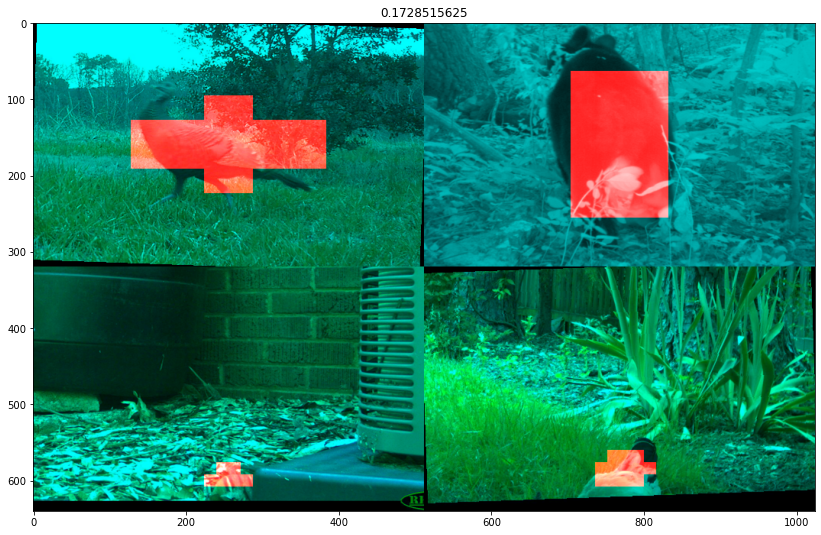

In [52]:
pmap_with_img =  np.array(img_check)[0]
print('pmap_with_img', pmap_with_img.shape)
pmap_with_img = pmap_with_img.astype(np.uint8)
pmap_add = np.expand_dims(pmap_add, -1)
pmap = (pmap_add>0).astype(np.uint8)*255
print('pmap', pmap.shape)
mix_rgb = np.concatenate((pmap, pmap_with_img[:,:,1:]),-1)
plt.figure(figsize=(14,14))
plt.imshow(mix_rgb)
plt.title(str(np.mean(pmap_add)))

In [99]:
#warm up clipvalue=10. !
#optimizer = tf.optimizers.SGD(learning_rate=1e-5, clipvalue=5.)#, scratch
optimizer = tf.optimizers.SGD(learning_rate=1e-1, clipvalue=10)
#optimizer = tf.optimizers.SGD(learning_rate=1e-1)#, clipvalue=10.
model.compile(loss=loss_fn, optimizer=optimizer, metrics=[recall, precision, accuracy])#

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_dir,
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=0,
        save_freq=100
    )
]

In [100]:
loss_list = []
loss_var_list = []
load_weight()
print(len(input_list_train), len(input_list_test))

latest_checkpoint retinanet/animal
920 1464


In [101]:
d = model.evaluate(val_dataset)
# 0.28, 0.35

209/209 [==============================] - 40s 193ms/step - loss: 6.1988 - recall: 0.2060 - precision: 0.3892 - accuracy: 0.3992


In [48]:
d = model.evaluate(train_dataset)# best 0.86/0.99

8/8 [==============================] - 1s 138ms/step - loss: nan - recall: 0.4325 - precision: 0.0031 - accuracy: 0.0121


In [102]:
epochs = 10000
hist = model.fit(
    train_dataset.take(1000),
    validation_data=None,#val_dataset.take(2)
    epochs=epochs,
    callbacks=callbacks_list,#callbacks_list
    verbose=1,
)

Epoch 1/10000
131/131 [==============================] - 62s 477ms/step - loss: 5.3656 - recall: 0.4146 - precision: 0.5879 - accuracy: 0.2960
Epoch 2/10000
131/131 [==============================] - 63s 477ms/step - loss: 5.3647 - recall: 0.4149 - precision: 0.5903 - accuracy: 0.2908
Epoch 3/10000
131/131 [==============================] - 60s 457ms/step - loss: 5.3245 - recall: 0.4184 - precision: 0.5910 - accuracy: 0.3001
Epoch 4/10000
131/131 [==============================] - 61s 465ms/step - loss: 5.3440 - recall: 0.4154 - precision: 0.5879 - accuracy: 0.2968
Epoch 5/10000
131/131 [==============================] - 66s 507ms/step - loss: 5.3274 - recall: 0.4196 - precision: 0.5940 - accuracy: 0.2972
Epoch 6/10000
131/131 [==============================] - 66s 505ms/step - loss: 5.3082 - recall: 0.4177 - precision: 0.5892 - accuracy: 0.2968
Epoch 7/10000
131/131 [==============================] - 66s 503ms/step - loss: 5.3212 - recall: 0.4199 - precision: 0.5950 - accuracy: 0.2970

KeyboardInterrupt: 

loss_list.extend(hist.history['loss'])
plt.plot(np.array(loss_list).reshape([-1]),label='train')

In [96]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5, nms_iou_threshold=0.1)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    return tf.expand_dims(image, axis=0), ratio

In [97]:
def check_test(test_datas, bboxs_label, step=1):
    i = 0
    for image, cbbox in test_datas: 
        if i%step==0:
            bbox_annotation = bboxs_label[i]
            scale = np.array(image.shape[:2])
            scale = np.reshape(scale, [1, 2])
            scale = np.concatenate((scale, scale), 1)
            gt_bbox = bbox_annotation[ :, 1:] * scale
            input_image, ratio = prepare_image(image)
            if is_pretrain_backbone:
                input_image = tf.keras.applications.resnet.preprocess_input(input_image)#?        
            detections = inference_model.predict(input_image)        
            #print('detections', detections)
            num_detections = detections.valid_detections[0]
            print('num_detections', num_detections, image.shape, input_image.shape, np.min(input_image), np.max(input_image))
            print('cls', np.unique(detections.nmsed_classes[0][:num_detections]))
            cls_h = 1 + detections.nmsed_classes[0][:num_detections].astype(np.int)
            #cls_h = np.minimum(cls_h, num_classes-2)
            
            visualize_detections(
                image,
                detections.nmsed_boxes[0][:num_detections] / ratio,
                cls_h,
                detections.nmsed_scores[0][:num_detections],
                boxes_gt=gt_bbox
            )
        i+=1

num_detections 5 (640, 1024, 3) (1, 640, 1024, 3) 0.0 255.0
cls [ 6. 16. 17. 22.]


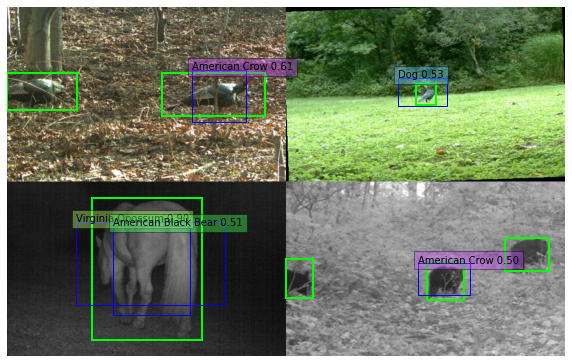

In [106]:
check_test(dataset, bbox_list_train, step=1300)

num_detections 1 (1080, 1920, 3) (1, 640, 1024, 3) 0.0 255.0
cls [16.]


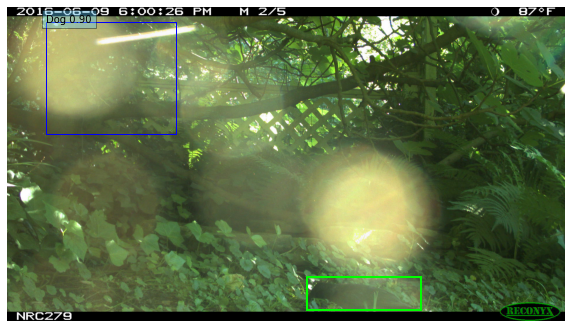

In [105]:
check_test(dataset_test, bbox_list_test, step=1490)

for var in model.trainable_variables:
    print(var.name)